Benchmark implementations of the No-U-Turn Sampler (NUTS) in several Probabilistic Programming Languages available in python packages: PyMc, Numpyro and Cmdstanpy, for inference on an ODE model of NeuroImaging.

author: Nina Baldy, INS AMU

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import jax

In [3]:
import numpyro as npr
from numpyro.infer import MCMC, NUTS, init_to_value
npr.set_platform("cpu")

/mnt/data/tng/phd/DCM/DCM_ERP_new/.pymc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pymc as pm
import pytensor
import pymc.sampling.jax as pmjax

In [5]:
import cmdstanpy

In [6]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) 

In [7]:
cmdstanpy_output_dir = cwd + '/output_cmdstanpy/'
! mkdir -p $cmdstanpy_output_dir

In [8]:
from Helper.ERPhelper import *
import PPL_models

In [9]:
for pckg in [np, jax, npr, pm, cmdstanpy, az] :
    print(f" {pckg.__name__} version: {pckg.__version__}")

 numpy version: 1.24.3
 jax version: 0.4.23
 numpyro version: 0.14.0
 pymc version: 5.11.0
 cmdstanpy version: 1.2.2
 arviz version: 0.18.0


In [10]:
import multiprocessing

def setup_parallelization():
    num_cores = multiprocessing.cpu_count()
    os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={num_cores}"
    jax.config.update("jax_enable_x64", True)
    jax.config.update("jax_platform_name", "cpu")
    print(f"Number of CPU cores: {num_cores}")

In [11]:
enable_parallelization = True

if enable_parallelization:
    setup_parallelization()
    print("Parallelizing chains.")
else:
    print("Skipping parallelization setup.")

Number of CPU cores: 8
Parallelizing chains.


In [12]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [13]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"] 

In [14]:
def mse(x, y) :
    return np.mean((x - y)**2)

## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simuations in the repo. The neural mass model used in this example has often been used in dynamical cuasal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

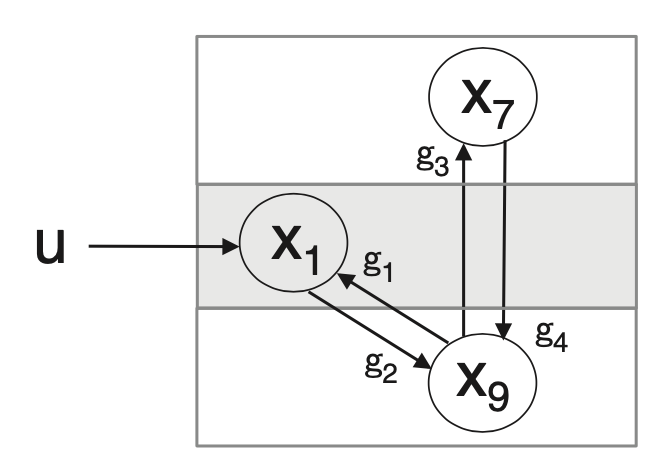

In [15]:
from IPython.display import Image
Image(filename='../Images/model.png', width=400) 

This ODE given by:




\begin{equation}
    \begin{aligned}
    \dot x_1(t) &= x_4 (t) \\
    \dot x_2(t) &= x_5(t) \\
    \dot x_3(t) &= \dfrac{h_e}{\tau_e} \left( g_1 \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} - 0.5 \right) + u \right) - \dfrac{x_1(t)}{\tau_e^2} - \dfrac{2 x_4(t)}{\tau_e} \\
    \dot x_5(t) &= \dfrac{g_2 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_1 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_2(t)}{\tau_e^2} - \dfrac{2 x_5(t)}{\tau_e} \\
    \dot x_6(t) &= \dfrac{g_4 h_i}{\tau_i}  \left( 
    \dfrac{1}{\exp^{-0.56 x_7 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_3(t)}{\tau_i^2} - \dfrac{2 x_6(t)}{\tau_i} \\
    \dot x_7(t) &= x_8(t) \\
    \dot x_8(t) &= \dfrac{g_3 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_7(t)}{\tau_e^2} - \dfrac{2 x_8(t)}{\tau_e} \\
    \dot x_9(t) &= x_5(t) - x_6(t)
\end{aligned}
\end{equation}




The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of nerural populations.  Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.  

$x(0)$ is the initial values of the states needed to solve the ODE, and are fixed to zero for all variables. 


The unknown model parameters which represent the following:  
* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ are maximum amplitude of excitatory (e), and inhibitory (i) post-synaptic potential.
* $\tau_{e, i}$ are the excitatory (e), and inhibitory (i) rate-constant of the membrane,
* $u$  is the input to the neural population.

## Load data

In [16]:
data_dict = dict(np.load("ERP_data.npz"))

In [17]:
data_dict.keys()

dict_keys(['nd', 'nn', 'nt', 'ns', 'nt_model', 't0', 'tend', 'dt', 'ts', 'ds', 'x_init', 'xpy_model', 'xpy_obs', 'xs_obs', 'theta_true', 'alpha', 'eps', 'sig', 'xlim'])

In [18]:
theta_true = data_dict['theta_true']
n_params = len(theta_true)
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']
obs_noise = data_dict['eps']

In [19]:
n_states = data_dict['ns'] ; ts_obs = data_dict['ts'] ; ds = data_dict['ds'] ;
nt = data_dict['nt'] ;
dt = data_dict['dt']/data_dict['ds'] ; n_steps_model = data_dict['nt_model']
ts_model = np.linspace(data_dict['t0'], data_dict['tend'], n_steps_model)
xpy_obs = data_dict['xpy_obs'] ; xpy_model = data_dict['xpy_model'][::ds]

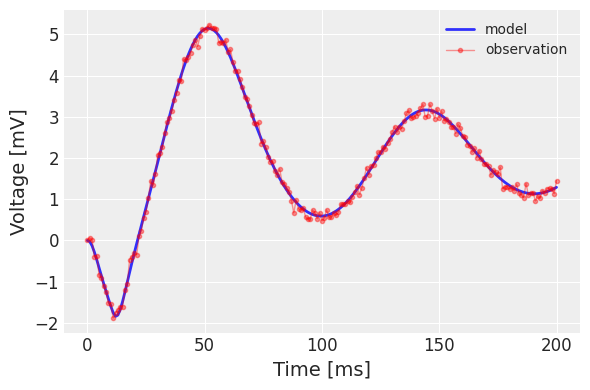

In [20]:
plot_observation(ts_obs, xpy_model, ts_obs, xpy_obs);

## Prior

In [21]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)
prior_specs = dict(shape=shape, rate=rate, scale=scale)

In [22]:
n_ = 1000
prior_samples = np.random.gamma(prior_specs['shape'], prior_specs['scale'], size=(n_, n_params))
prior_samples_dict = dict(zip(my_var_names, prior_samples.T))

## NUTS hyperparameters

In [23]:
# ODE integration initial state and steps

x_init_float64 = list(np.zeros(n_states, dtype=np.float64))
n_steps = n_steps_model

In [24]:
# sampler initialization: a fair common starting point
np.random.seed(0)
_, low_prob_sample_vals, q_ = low_prob_sample(my_var_names, prior_samples_dict)
init_values = dict(zip(my_var_names, low_prob_sample_vals))

In [25]:
# global parameters
#these are the default values in most softwares

global_maxtreedepth = 10
global_accept = 0.8

In [26]:
#iterations

tune, draws, n_chains = 200, 200, 4

## Benchmark quantities

In [27]:
def compute_marks(az_trace) :
    ess_bulk = az.ess(az_trace, var_names=my_var_names, method='bulk').to_array().values
    ess_tail = az.ess(az_trace, var_names=my_var_names, method='tail').to_array().values
    r_hat = az.rhat(az_trace, var_names=my_var_names).to_array().values
    mse_fit = mse(xpy_obs, az_trace.posterior['xpy_model'].mean(axis=(0, 1)).to_numpy().flatten())
    divergences = int(az_trace.sample_stats.diverging.sum().values)
    accept = float(az_trace.sample_stats.acceptance_rate.mean().values)
    
    
    return {'ESS bulk': ess_bulk, 
            'ESS tail': ess_tail, 
            'mean ESS bulk': np.mean(ess_bulk),
            'mean ESS tail': np.mean(ess_tail),
            'r hat': r_hat,
            'mean r hat': np.mean(r_hat),
            'MSE fit': mse_fit, 
            'n_divergences': divergences, 
            'accept_rate': accept}
    
def append_marks(df, setup, tune, draws, chains, time, marks_dict) :
    return df._append({'setup': setup, 
                       'n_warmup': tune,
                       'n_sample': draws,
                       'n_chain': chains,
                       'time': time,
                       **{k:v for k, v in marks_dict.items()}
                      }, ignore_index=True)

In [28]:
bench_df = pd.DataFrame({})

## PyMC x Blackjax

In [29]:
pymc_data = pd.DataFrame(dict(xpy_obs = xpy_obs, obs_noise=obs_noise))
pymc_integration_specs = {'init_state': x_init_float64, 'dt': dt, 'n_steps': n_steps, 'ds': ds}

In [30]:
pymc_model = PPL_models.build_model_pymc(pymc_data, prior_specs, pymc_integration_specs)

In [31]:
start_time = time.time()

with pymc_model:
    trace_pymc_blackjax = pmjax.sample_blackjax_nuts(
        tune=tune, 
        draws=draws, 
        chains=n_chains,
        target_accept=global_accept,
        progressbar=False,
        postprocessing_backend='cpu',
        initvals=init_values)
    
time_pymc_blackjax = time.time() - start_time
print("---running with pymc x blackjax took: %s seconds ---" % time_pymc_blackjax)

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


---running with pymc x blackjax took: 59.076367139816284 seconds ---


In [32]:
az.summary(trace_pymc_blackjax, var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.548,0.117,0.300,0.747,0.005,0.003,641.0,467.0,1.01
g_2,0.651,0.078,0.513,0.783,0.004,0.003,481.0,512.0,1.00
g_3,0.141,0.022,0.103,0.184,0.001,0.001,604.0,554.0,1.00
g_4,0.216,0.033,0.157,0.280,0.001,0.001,612.0,421.0,1.00
delta,12.075,0.392,11.346,12.753,0.017,0.012,508.0,470.0,1.01
tau_i,7.684,0.085,7.532,7.843,0.003,0.002,751.0,723.0,1.00
h_i,19.693,3.396,13.759,26.030,0.138,0.098,582.0,437.0,1.01
tau_e,5.874,0.174,5.574,6.202,0.008,0.005,516.0,462.0,1.00
h_e,1.900,0.226,1.525,2.348,0.010,0.007,491.0,523.0,1.00
u,3.255,0.513,2.386,4.245,0.019,0.013,740.0,556.0,1.00


In [33]:
marks_pymc = compute_marks(trace_pymc_blackjax)

In [34]:
bench_df = append_marks(bench_df, 
                        setup='pymc x blackjax', 
                        tune=tune, 
                        draws=draws, 
                        chains=n_chains,
                        time=time_pymc_blackjax,
                        marks_dict=marks_pymc)

## Numpyro

In [35]:
numpyro_data = dict(xpy_obs = xpy_obs, obs_noise=obs_noise, nt_obs=nt)
numpyro_integration_specs = {'init_state': np.array(x_init_float64), 'ts': ts_model, 'ds': ds}

In [36]:
init_numpyro = init_to_value(values=init_values)

In [37]:
rng_key = jax.random.PRNGKey(0) #don't define the rng_key before running pymc, it messes it up for some reason

In [38]:
# NUTS set up for numpyro
kernel = NUTS(PPL_models.build_model_numpyro, 
              target_accept_prob=global_accept, 
              max_tree_depth=global_maxtreedepth, 
              dense_mass=False, 
              adapt_step_size=True,
              init_strategy=init_numpyro)

mcmc = MCMC(kernel, 
            num_warmup=tune, 
            num_samples=draws, 
            num_chains=n_chains, 
            chain_method='parallel',
            progress_bar=False)

#run NUTS
start_time = time.time()

mcmc.run(rng_key, numpyro_data, prior_specs, numpyro_integration_specs,
         extra_fields=('potential_energy', 'num_steps', 'diverging', 'mean_accept_prob'))

time_numpyro = time.time() - start_time
print("---running with numpyro took: %s seconds ---" % time_numpyro)

---running with numpyro took: 55.53223204612732 seconds ---


In [39]:
trace_numpyro = az.from_numpyro(mcmc)
trace_numpyro.sample_stats['acceptance_rate'] = trace_numpyro.sample_stats.mean_accept_prob

In [40]:
az.summary(trace_numpyro, var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.533,0.124,0.318,0.770,0.005,0.003,634.0,429.0,1.00
g_2,0.655,0.078,0.523,0.806,0.004,0.003,413.0,432.0,1.01
g_3,0.142,0.021,0.105,0.182,0.001,0.001,499.0,585.0,1.00
g_4,0.214,0.034,0.157,0.282,0.001,0.001,617.0,522.0,1.00
delta,12.220,0.389,11.466,12.931,0.019,0.014,406.0,559.0,1.01
tau_i,7.705,0.091,7.519,7.854,0.004,0.003,518.0,592.0,1.01
h_i,19.817,3.594,13.642,26.663,0.165,0.118,486.0,394.0,1.00
tau_e,5.774,0.167,5.469,6.101,0.008,0.006,414.0,535.0,1.00
h_e,1.910,0.223,1.503,2.331,0.011,0.008,420.0,373.0,1.01
u,3.208,0.545,2.312,4.346,0.020,0.014,682.0,495.0,1.00


In [41]:
marks_numpyro = compute_marks(trace_numpyro)

In [42]:
bench_df = append_marks(bench_df, 
                        setup='numpyro', 
                        tune=tune, 
                        draws=draws, 
                        chains=n_chains,
                        time=time_numpyro,
                        marks_dict=marks_numpyro)

## Stan with Cmdstanpy

In [43]:
stan_data = data_dict.copy()
stan_data['n_params'] = n_params
stan_data['obs_err'] = data_dict['eps']
stan_data['prior_gamma_shape'] = prior_specs['shape']
stan_data['prior_gamma_rate'] = prior_specs['rate']

In [44]:
model_name = 'DCM_ERP_sampling_GammaPrior'
stanfile = os.path.join(cwd, model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

11:28:42 - cmdstanpy - WARNING - CmdStanModel.compile() is deprecated and will be removed in the next major version. To compile a model, use the CmdStanModel() constructor or cmdstanpy.compile_stan_file().


In [45]:
start = time.time()

hmc_fit = model.sample(data=stan_data, 
                       iter_warmup=tune, 
                       iter_sampling=draws, 
                       chains=n_chains,
                       output_dir=cmdstanpy_output_dir,
                       adapt_delta=global_accept, 
                       max_treedepth=int(global_maxtreedepth), 
                       inits=init_values,
                       show_progress=False)

time_cmdstan = time.time() - start_time
print("---running with cmdstanpy took: %s seconds ---" % time_cmdstan)

15:25:14 - cmdstanpy - INFO - CmdStan start processing
15:25:14 - cmdstanpy - INFO - Chain [1] start processing
15:25:14 - cmdstanpy - INFO - Chain [2] start processing
15:25:14 - cmdstanpy - INFO - Chain [3] start processing
15:25:14 - cmdstanpy - INFO - Chain [4] start processing
15:39:17 - cmdstanpy - INFO - Chain [4] done processing
15:39:36 - cmdstanpy - INFO - Chain [2] done processing
15:39:36 - cmdstanpy - INFO - Chain [1] done processing
15:40:49 - cmdstanpy - INFO - Chain [3] done processing
15:40:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Benchmark/DCM_ERP_sampling_GammaPrior.stan', line 55, column 4 to column 59)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Benchmark/DCM_ERP_sampling_GammaPrior.stan', line 55, column 4 to column 59)
	Exception: gamma_lpdf: Rand

---running with cmdstanpy took: 993.8616540431976 seconds ---


In [46]:
trace_stan = az.from_cmdstanpy(hmc_fit)

In [47]:
az.summary(trace_stan, var_names=my_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g_1,0.540,0.123,0.321,0.769,0.004,0.003,768.0,518.0,1.01
g_2,0.649,0.071,0.524,0.783,0.003,0.003,472.0,423.0,1.01
g_3,0.141,0.022,0.104,0.184,0.001,0.001,706.0,582.0,1.00
g_4,0.215,0.033,0.154,0.273,0.001,0.001,643.0,463.0,1.00
delta,12.168,0.403,11.448,12.927,0.018,0.013,477.0,367.0,1.01
tau_i,7.715,0.090,7.543,7.882,0.004,0.003,593.0,543.0,1.00
h_i,19.731,3.612,13.257,26.188,0.144,0.103,629.0,443.0,1.00
tau_e,5.796,0.175,5.470,6.101,0.008,0.006,481.0,484.0,1.01
h_e,1.919,0.206,1.526,2.291,0.009,0.007,479.0,446.0,1.01
u,3.229,0.552,2.262,4.293,0.021,0.015,714.0,658.0,1.00


In [48]:
marks_stan = compute_marks(trace_stan)

In [50]:
bench_df = append_marks(bench_df, 
                        setup='cmdstanpy', 
                        tune=tune, 
                        draws=draws, 
                        chains=n_chains,
                        time=time_cmdstan,
                        marks_dict=marks_stan)

## Results

In [51]:
bench_df['rel. ESS bulk'] = bench_df['mean ESS bulk'] / (bench_df['n_sample'] *  bench_df['n_chain'])
bench_df['rel. ESS tail'] = bench_df['mean ESS tail'] / (bench_df['n_sample'] * bench_df['n_chain'])

In [52]:
bench_df[['setup', 'time', 'mean ESS bulk', 'mean ESS tail', 
          'rel. ESS bulk', 'rel. ESS tail', 'mean r hat', 'n_sample', 'n_warmup',
          'n_divergences', 'accept_rate']]

,setup,time,mean ESS bulk,mean ESS tail,rel. ESS bulk,rel. ESS tail,mean r hat,n_sample,n_warmup,n_divergences,accept_rate
0,pymc x blackjax,59.076367,592.603016,512.672924,0.740754,0.640841,1.004680,200,200,0,0.940266
1,numpyro,55.532232,508.889784,491.537773,0.636112,0.614422,1.004200,200,200,0,0.919528
2,cmdstanpy,993.861654,596.245749,492.625951,0.745307,0.615782,1.005818,200,200,0,0.936530


## Setup info

In [53]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon May 13 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.24.0

numpyro   : 0.14.0
pymc      : 5.11.0
pytensor  : 2.18.6
sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
pandas    : 2.2.2
seaborn   : 0.13.2
cmdstanpy : 1.2.2
matplotlib: 3.8.4
numpy     : 1.24.3
arviz     : 0.18.0
jax       : 0.4.23

Watermark: 2.4.3



In [54]:
!  lscpu | head -n 16

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          8
On-line CPU(s) list:             0-7
Vendor ID:                       GenuineIntel
Model name:                      Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz
CPU family:                      6
Model:                           158
Thread(s) per core:              2
Core(s) per socket:              4
Socket(s):                       1
Stepping:                        9
CPU max MHz:                     4200.0000
CPU min MHz:                     800.0000
